## Env

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
import xgboost as xgb
import bisect

from scipy import stats
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor

| 항목 | 설명     |
|-----|----------|
| X1  | 작업번호 |
| X2  | 마킹길이 |
| X3  | 절단길이 |
| X4  | 철판두께 |
| X5  | 철판재질 |
| X6  | 절단갯수 |
| X7  | 작업장   |
| X8  | 작업자   |
| Y1  | 마킹시간 |
| Y2  | 절단시간 |


In [2]:
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
train = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\train.csv').drop(['X1'], axis=1)
test = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\test.csv').drop(['Id', 'X1'], axis=1)

display(train.head())
display(test.head())

,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,56.3,67.5,22.5,AH32,4,97,PL973,467,2241
1,115.0,67.0,13.0,AH32,2,27,PL271,1058,1163
2,59.2,44.6,18.0,AH32-TM,1,14,PL141,270,1094
3,52.1,97.4,15.0,A,17,24,PL242,391,2604
4,42.9,58.7,14.5,A,4,23,PL233,232,1564


,X2,X3,X4,X5,X6,X7,X8
0,80.6,104.8,11.0,A,29,23,PL234
1,141.8,34.2,17.5,A,2,91,PL911
2,77.2,103.3,17.0,A,10,97,PL973
3,95.5,131.0,18.0,A,2,23,PL234
4,91.7,36.1,19.0,AH32,1,27,PL271


In [4]:
train.X6.value_counts(ascending = False)

X6
1      33506
2      20320
4       6178
6       3732
3       3373
       ...  
348        1
183        1
165        1
220        1
175        1
Name: count, Length: 207, dtype: int64

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121754 entries, 0 to 121753
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   X2      121754 non-null  float64
 1   X3      121754 non-null  float64
 2   X4      121754 non-null  float64
 3   X5      121754 non-null  object 
 4   X6      121754 non-null  int64  
 5   X7      121754 non-null  int64  
 6   X8      121754 non-null  object 
 7   Y1      121754 non-null  int64  
 8   Y2      121754 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 8.4+ MB


## Preprocessing

In [6]:
train['X8'] = train['X8'].str.extract(r'(PL|PS)')
test['X8'] = test['X8'].str.extract(r'(PL|PS)')

In [3]:
def remove_outliers_with_k(column, k=1.5):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (k * IQR)
    upper_bound = Q3 + (k * IQR)
    return (column >= lower_bound) & (column <= upper_bound)

train = train[remove_outliers_with_k(train['Y1'], k=5) & remove_outliers_with_k(train['Y2'], k=5)]

train = train[(train['X2'] <= 445.300000) | (train['X3'] <= 621.300000) | (train['X4'] <= 36.000000) | (train['X6'] <= 262.000000)]

train = train.reset_index(drop=True)

c:\Users\dlwks\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


구간 1: (11.803231983560167, 15.399598828764725)
구간 2: (15.399598828764725, 19.217450670446116)
구간 3: (19.217450670446116, 23.3012287088808)
구간 4: (23.3012287088808, 31.060773480663194)


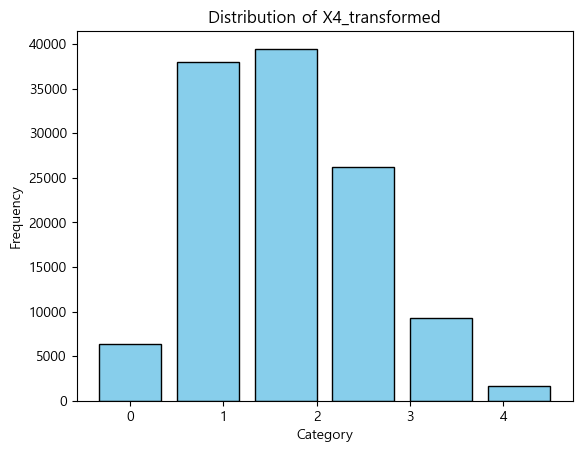

In [9]:
from sklearn.cluster import KMeans

data = np.array(train.X4).reshape(-1, 1)

# K-평균 클러스터링을 사용하여 5개의 클러스터로 나눔
kmeans = KMeans(n_clusters=5, random_state=0).fit(data)

# 클러스터의 중심값을 얻어와서 정렬
cluster_centers = kmeans.cluster_centers_.flatten()
cluster_centers.sort()

# 각 클러스터의 중심값을 구간으로 사용
intervals = [(cluster_centers[i], cluster_centers[i+1]) for i in range(len(cluster_centers)-1)]

# 결과 출력
for i, interval in enumerate(intervals):
    print(f'구간 {i+1}: {interval}')

def convert_to_category(value):
    if value <= 11.803731516247275:
        return 0
    elif value <= 15.399819023183683:
        return 1
    elif value <= 19.21905648665441:
        return 2
    elif value <= 23.299184835350026:
        return 3
    elif value <= 31.065439163971163:
        return 4
    else:
        return 5

train['X4_transformed'] = train['X4'].apply(convert_to_category)
test['X4_transformed'] = test['X4'].apply(convert_to_category)

train

In [9]:
data = np.array(train.X6).reshape(-1, 1)

# K-평균 클러스터링을 사용하여 5개의 클러스터로 나눔
kmeans = KMeans(n_clusters=5, random_state=0).fit(data)

# 클러스터의 중심값을 얻어와서 정렬
cluster_centers = kmeans.cluster_centers_.flatten()
cluster_centers.sort()

# 각 클러스터의 중심값을 구간으로 사용
intervals = [(cluster_centers[i], cluster_centers[i+1]) for i in range(len(cluster_centers)-1)]

# 결과 출력
for i, interval in enumerate(intervals):
    print(f'구간 {i+1}: {interval}')

def convert_to_category(value):
    if value <= 2.829007129990794:
        return 0
    elif value <= 18.537454928493617:
        return 1
    elif value <= 40.37791021056714:
        return 2
    elif value <= 72.18129938542535:
        return 3
    elif value <= 128.1146209386285:
        return 4
    else:
        return 5

train['X6_transformed'] = train['X6'].apply(convert_to_category)
test['X6_transformed'] = test['X6'].apply(convert_to_category)

train

c:\Users\dlwks\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


구간 1: (2.594812718059666, 17.067089255482824)
구간 2: (17.067089255482824, 37.7851744407964)
구간 3: (37.7851744407964, 67.02383277983927)
구간 4: (67.02383277983927, 117.52917981072554)


,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2,X4_transformed,X6_transformed
0,134764,56.3,67.5,22.5,AH32,4,97,PL,467,2241,3,1
1,9854,115.0,67.0,13.0,AH32,2,27,PL,1058,1163,1,0
2,94365,59.2,44.6,18.0,AH32-TM,1,14,PL,270,1094,2,0
3,110641,52.1,97.4,15.0,A,17,24,PL,391,2604,1,1
4,100159,42.9,58.7,14.5,A,4,23,PL,232,1564,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
120835,147050,98.4,89.5,10.0,AE,8,21,PS,906,1226,0,1
120836,151590,48.0,51.0,23.0,LAH36,1,23,PL,175,1540,3,0
120837,152421,42.5,30.2,34.0,EH36,5,27,PL,376,1492,5,1
120838,161172,22.1,15.3,36.0,AH36TL,8,97,PL,85,723,5,1


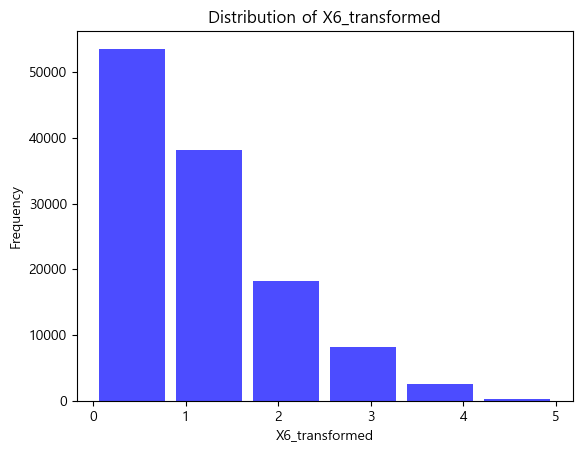

In [10]:
plt.hist(train['X6_transformed'], bins=6, color='blue', alpha=0.7, rwidth=0.85)

# 플롯 설정
plt.title('Distribution of X6_transformed')
plt.xlabel('X6_transformed')
plt.ylabel('Frequency')
plt.xticks(range(6))  # X축 값 범위 설정

# 플롯 출력
plt.show()

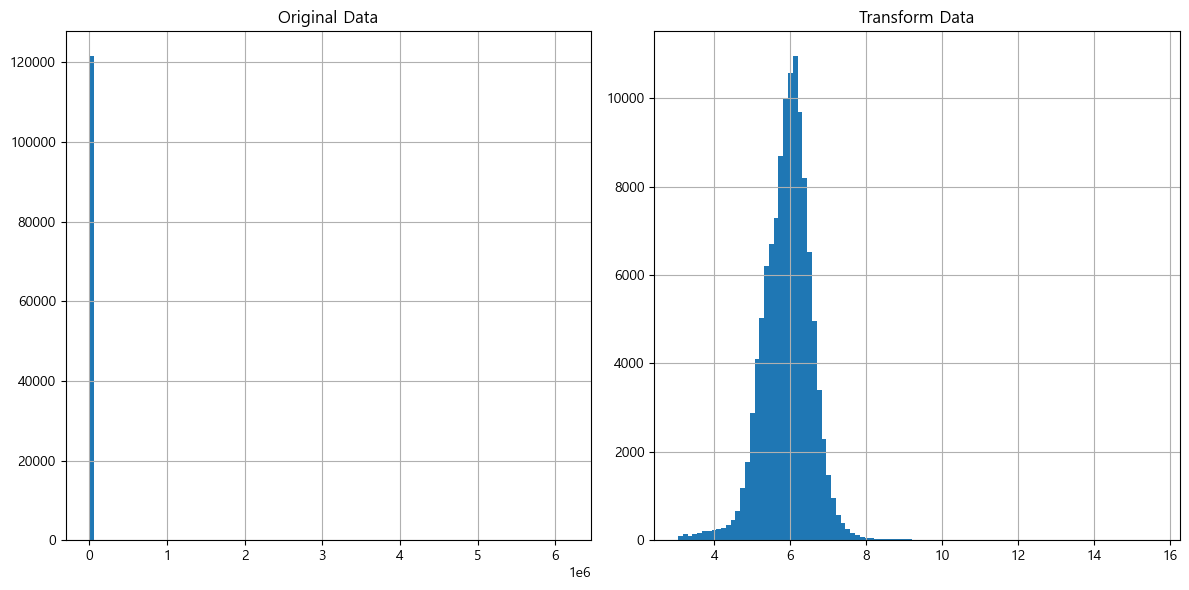

In [7]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
train['Y1'].hist(bins=100)
plt.title('Original Data')

train = train[train['Y1'] != 0].reset_index(drop=True)

plt.subplot(1, 2, 2)
train['Y1_trans'] = np.log1p(train['Y1'])
train = train[(train['Y1_trans'] >= 3)].reset_index(drop=True)
train['Y1_trans'].hist(bins=100)
plt.title('Transform Data')

plt.tight_layout()
plt.show()

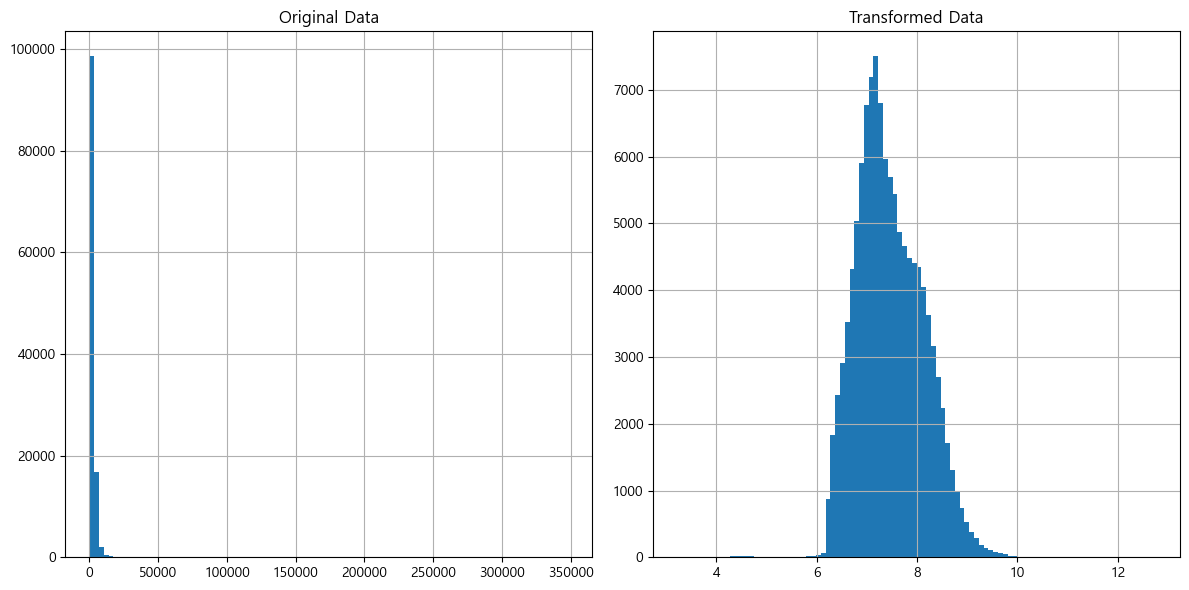

In [8]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
train['Y2'].hist(bins=100)
plt.title('Original Data')

train = train[train['Y2'] != 0].reset_index(drop=True)

plt.subplot(1, 2, 2)
train['Y2_trans'] = np.log1p(train['Y2'])
train = train[(train['Y2_trans'] >= 3)].reset_index(drop=True)
train['Y2_trans'].hist(bins=100)
plt.title('Transformed Data')

plt.tight_layout()
plt.show()

In [13]:
categorical_features = ['X5', 'X8']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

Encoding features: 100%|██████████| 2/2 [00:00<00:00, 20.15it/s]


In [14]:
test.drop(columns = ['Id'], inplace = True)

In [15]:
# drop_indices = train[(train['Y1'] >= 2500) |
#                      (train['Y2'] >= 20000) |
#                      (train['X2'] >= 500) |
#                      (train['X6'] >= 265)].index

# train = train.drop(drop_indices)

In [16]:
# train = train[(train['Y1'] > 150) & (train['Y1'] <= 67000) & (train['Y2'] > 150) & (train['Y2'] <= 67000)]

In [17]:
mmtime = train.groupby('X5')['Y1'].mean()
mctime = train.groupby('X5')['Y2'].mean()

wmtime = train.groupby('X7')['Y1'].mean()
wctime = train.groupby('X7')['Y2'].mean()

manmtime = train.groupby('X8')['Y1'].mean()
manctime = train.groupby('X8')['Y2'].mean()

train['X5_mmtime'] = train['X5'].map(mmtime)
train['X5_mctime'] = train['X5'].map(mctime)

train['X7_wmtime'] = train['X7'].map(wmtime)
train['X7_wctime'] = train['X7'].map(wctime)

train['X8_manmtime'] = train['X8'].map(manmtime)
train['X8_manctime'] = train['X8'].map(manctime)

test['X5_mmtime'] = test['X5'].map(mmtime)
test['X5_mctime'] = test['X5'].map(mctime)

test['X7_wmtime'] = test['X7'].map(wmtime)
test['X7_wctime'] = test['X7'].map(wctime)

test['X8_manmtime'] = test['X8'].map(manmtime)
test['X8_manctime'] = test['X8'].map(manctime)

train['Velo_cutting'] = train['X3'] / train['X4']
train['Velo_marking'] = train['X2'] / train['X4']

test['Velo_cutting'] = test['X3'] / test['X4']
test['Velo_marking'] = test['X2'] / test['X4']

train['Feed_cutting'] = train['Velo_cutting'] * train['X6']
train['Feed_marking'] = train['Velo_marking'] * train['X6']

test['Feed_cutting'] = test['Velo_cutting'] * test['X6']
test['Feed_marking'] = test['Velo_marking'] * test['X6']

grouped_mean = train.groupby(['X5', 'X7'])['Y1_trans'].mean()
train['X57_Y1mean'] = train.set_index(['X5', 'X7']).index.map(grouped_mean)
test['X57_Y1mean'] = test.set_index(['X5', 'X7']).index.map(grouped_mean)

grouped_mean = train.groupby(['X5', 'X8'])['Y1_trans'].mean()
train['X58_Y1mean'] = train.set_index(['X5', 'X8']).index.map(grouped_mean)
test['X58_Y1mean'] = test.set_index(['X5', 'X8']).index.map(grouped_mean)

grouped_mean = train.groupby(['X7', 'X8'])['Y1_trans'].mean()
train['X78_Y1mean'] = train.set_index(['X7', 'X8']).index.map(grouped_mean)
test['X78_Y1mean'] = test.set_index(['X7', 'X8']).index.map(grouped_mean)

grouped_mean = train.groupby(['X5', 'X7'])['Y2_trans'].mean()
train['X57_Y2mean'] = train.set_index(['X5', 'X7']).index.map(grouped_mean)
test['X57_Y2mean'] = test.set_index(['X5', 'X7']).index.map(grouped_mean)

grouped_mean = train.groupby(['X5', 'X8'])['Y2_trans'].mean()
train['X58_Y2mean'] = train.set_index(['X5', 'X8']).index.map(grouped_mean)
test['X58_Y2mean'] = test.set_index(['X5', 'X8']).index.map(grouped_mean)

grouped_mean = train.groupby(['X7', 'X8'])['Y2_trans'].mean()
train['X78_Y2mean'] = train.set_index(['X7', 'X8']).index.map(grouped_mean)
test['X78_Y2mean'] = test.set_index(['X7', 'X8']).index.map(grouped_mean)

train

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2,...,Velo_cutting,Velo_marking,Feed_cutting,Feed_marking,X57_Y1mean,X58_Y1mean,X78_Y1mean,X57_Y2mean,X58_Y2mean,X78_Y2mean
0,134764,56.3,67.5,22.5,9,4,97,0,467,2241,...,3.000000,2.502222,12.000000,10.008889,5.768731,5.840497,5.849957,7.664250,7.464328,7.681074
1,9854,115.0,67.0,13.0,9,2,27,0,1058,1163,...,5.153846,8.846154,10.307692,17.692308,5.963379,5.840497,6.051877,7.199187,7.464328,7.111587
2,94365,59.2,44.6,18.0,10,1,14,0,270,1094,...,2.477778,3.288889,2.477778,3.288889,5.610938,5.590404,5.591388,7.119486,7.161780,7.010217
3,110641,52.1,97.4,15.0,2,17,24,0,391,2604,...,6.493333,3.473333,110.386667,59.046667,6.213675,5.938317,6.237987,7.709582,7.436348,7.783008
4,100159,42.9,58.7,14.5,2,4,23,0,232,1564,...,4.048276,2.958621,16.193103,11.834483,5.911305,5.938317,5.842059,7.819309,7.436348,7.778358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116682,147050,98.4,89.5,10.0,7,8,21,1,906,1226,...,8.950000,9.840000,71.600000,78.720000,6.810142,6.810142,6.102258,7.112327,7.112327,7.652819
116683,151590,48.0,51.0,23.0,52,1,23,0,175,1540,...,2.217391,2.086957,2.217391,2.086957,5.170484,5.170484,5.842059,7.340187,7.340187,7.778358
116684,152421,42.5,30.2,34.0,38,5,27,0,376,1492,...,0.888235,1.250000,4.441176,6.250000,5.932245,5.932245,6.051877,7.308543,7.308543,7.111587
116685,161172,22.1,15.3,36.0,14,8,97,0,85,723,...,0.425000,0.613889,3.400000,4.911111,4.595273,5.798063,5.849957,6.712669,7.785585,7.681074


<Axes: xlabel='X2', ylabel='X3'>

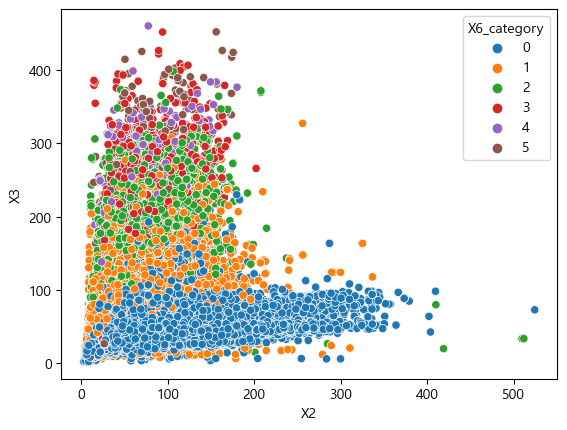

In [18]:
bins = [0, 15, 40, 70, 95, 110, float('inf')]

labels = [0, 1, 2, 3, 4, 5]

train['X6_category'] = pd.cut(train['X6'], bins = bins, labels = labels, include_lowest = True)
test['X6_category'] = pd.cut(test['X6'], bins = bins, labels = labels, include_lowest = True)

train.drop(columns = ['X6'], inplace = True)
test.drop(columns = ['X6'], inplace = True)

sns.scatterplot(x=train['X2'], y=train['X3'], hue = train['X6_category'].astype('category'))

In [19]:
train

,X1,X2,X3,X4,X5,X7,X8,Y1,Y2,X4_transformed,...,Velo_marking,Feed_cutting,Feed_marking,X57_Y1mean,X58_Y1mean,X78_Y1mean,X57_Y2mean,X58_Y2mean,X78_Y2mean,X6_category
0,134764,56.3,67.5,22.5,9,97,0,467,2241,3,...,2.502222,12.000000,10.008889,5.768731,5.840497,5.849957,7.664250,7.464328,7.681074,0
1,9854,115.0,67.0,13.0,9,27,0,1058,1163,1,...,8.846154,10.307692,17.692308,5.963379,5.840497,6.051877,7.199187,7.464328,7.111587,0
2,94365,59.2,44.6,18.0,10,14,0,270,1094,2,...,3.288889,2.477778,3.288889,5.610938,5.590404,5.591388,7.119486,7.161780,7.010217,0
3,110641,52.1,97.4,15.0,2,24,0,391,2604,1,...,3.473333,110.386667,59.046667,6.213675,5.938317,6.237987,7.709582,7.436348,7.783008,1
4,100159,42.9,58.7,14.5,2,23,0,232,1564,1,...,2.958621,16.193103,11.834483,5.911305,5.938317,5.842059,7.819309,7.436348,7.778358,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116682,147050,98.4,89.5,10.0,7,21,1,906,1226,0,...,9.840000,71.600000,78.720000,6.810142,6.810142,6.102258,7.112327,7.112327,7.652819,0
116683,151590,48.0,51.0,23.0,52,23,0,175,1540,3,...,2.086957,2.217391,2.086957,5.170484,5.170484,5.842059,7.340187,7.340187,7.778358,0
116684,152421,42.5,30.2,34.0,38,27,0,376,1492,5,...,1.250000,4.441176,6.250000,5.932245,5.932245,6.051877,7.308543,7.308543,7.111587,0
116685,161172,22.1,15.3,36.0,14,97,0,85,723,5,...,0.613889,3.400000,4.911111,4.595273,5.798063,5.849957,6.712669,7.785585,7.681074,0


In [20]:
# def remove_outliers(df, col_name):
#     uppper_bound = df[col_name].mean() + 3 * df[col_name].std()
#     lower_bound = df[col_name].mean() - 3 * df[col_name].std()

#     print(f"평균: {df[col_name].mean()}, 표준편차: {df[col_name].std()}")

#     return df[(df[col_name] < uppper_bound) & (df[col_name] > lower_bound)]

# columns_to_process = ['X2', 'X3', 'X4']

# for col in columns_to_process:
#     train = remove_outliers(train, col)

In [26]:
train_data1 = train[['X1', 'X2', 'X3', 'X4', 'X5', 'X6_category', 'X7', 'X8', 'X5_mmtime', 'X5_mctime', 'X7_wmtime', 'X7_wctime', 'X8_manmtime', 'X8_manctime', 
                'Velo_cutting' ,'Velo_marking', 'Feed_cutting', 'Feed_marking', 'X4_transformed','X6_transformed',
                'X57_Y1mean', 'X58_Y1mean', 'X78_Y1mean', 'X57_Y2mean', 'X58_Y2mean', 'X78_Y2mean']]

train_y1 = np.log1p(train['Y1'])
train_y2 = np.log1p(train['Y2'])

## Modeling

Model Tune for XGB.


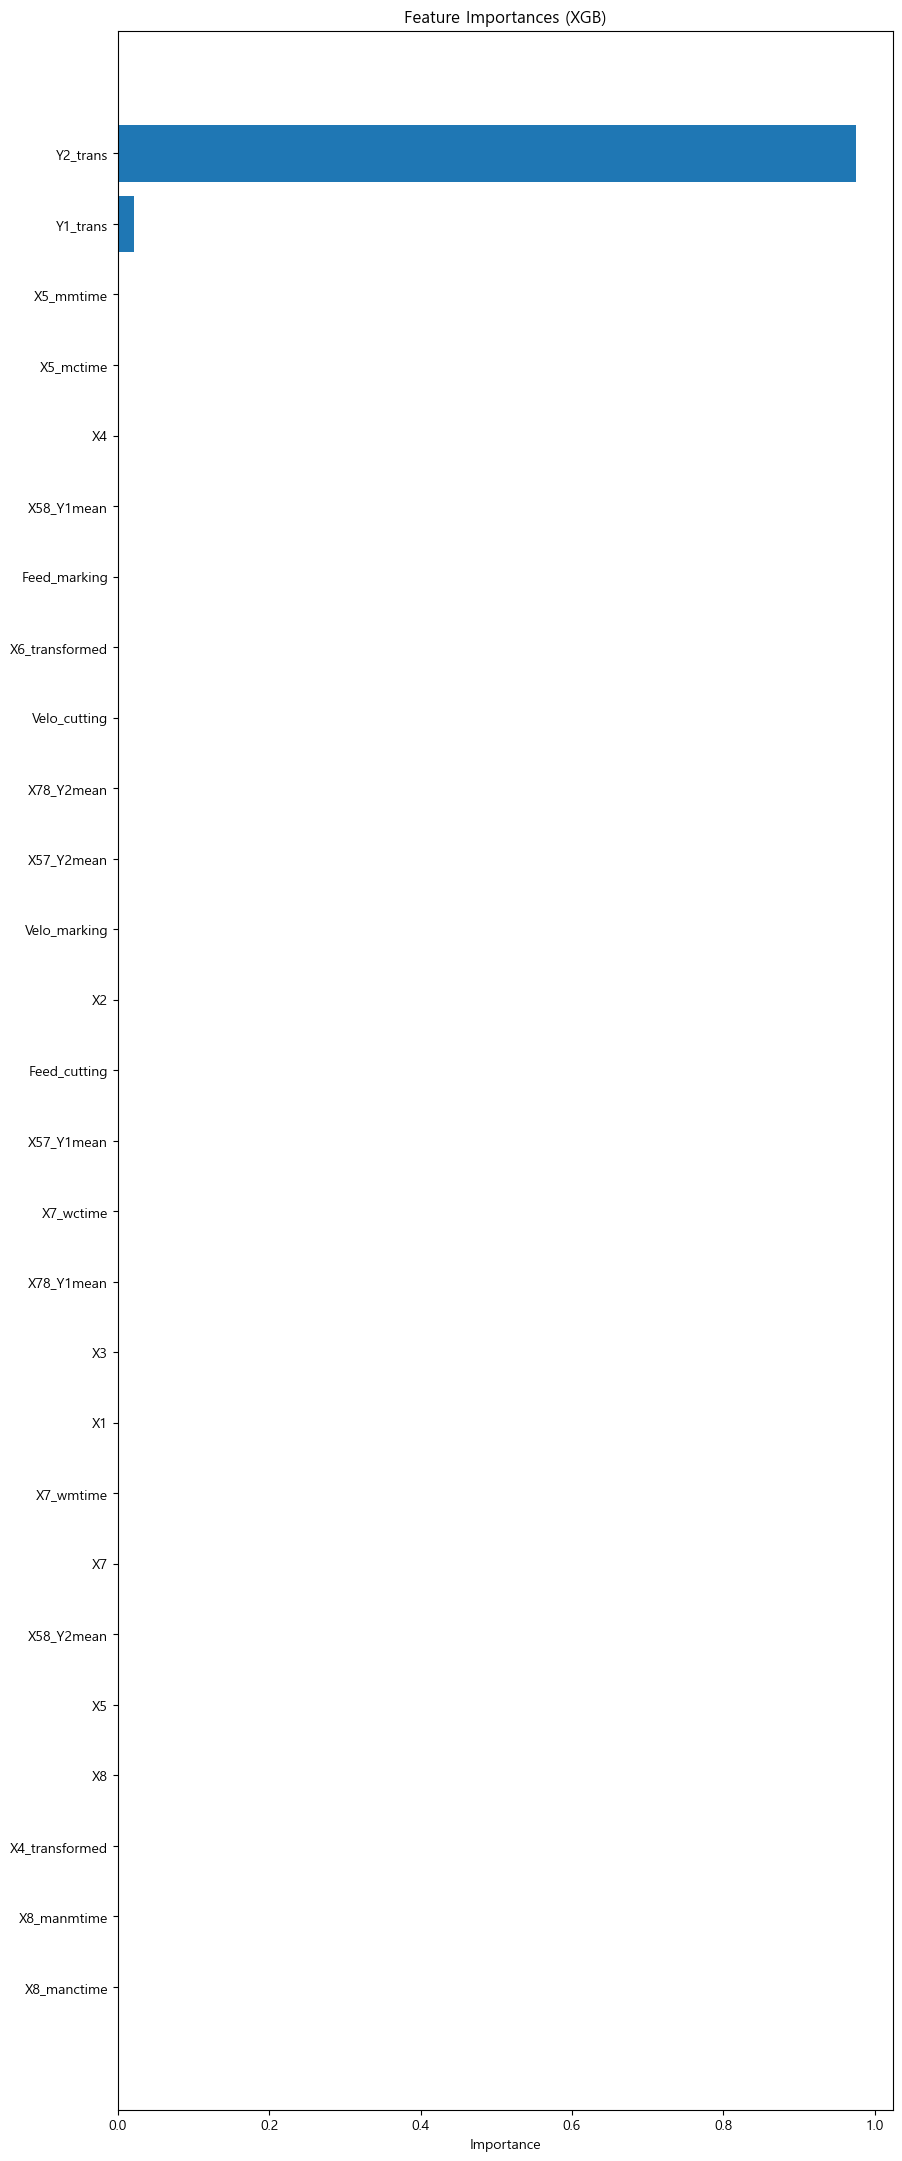

In [35]:
# def train_and_evaluate(model, model_name, X_train, y_train):
#     print(f'Model Tune for {model_name}.')
#     model.fit(X_train, y_train)
    
#     feature_importances = model.feature_importances_
#     sorted_idx = feature_importances.argsort()

#     plt.figure(figsize=(10, len(X_train.columns)))
#     plt.title(f"Feature Importances ({model_name})")
#     plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
#     plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
#     plt.xlabel('Importance')
#     plt.show()
    
#     return model, feature_importances

# X_train = train.drop(columns = ['X6_category','Y1', 'Y2'])
# Y_train = train[['Y1', 'Y2']]

# # Model Tune for XGB
# xgb_model, xgb_feature_importances = train_and_evaluate(xgb.XGBRegressor(), 'XGB', X_train, Y_train)

In [28]:
# threshold = 0.05
# low_importance_features = X_train.columns[xgb_feature_importances < threshold]

# train_data1 = train_data1.drop(columns = low_importance_features)
# test = test.drop(columns = low_importance_features)

In [29]:
numeric_cols = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6_category', 'X7', 'X8', 'X5_mmtime', 'X5_mctime', 'X7_wmtime', 'X7_wctime', 'X8_manmtime', 'X8_manctime', 
                'Velo_cutting' ,'Velo_marking', 'Feed_cutting', 'Feed_marking', 'X4_transformed','X6_transformed',
                'X57_Y1mean', 'X58_Y1mean', 'X78_Y1mean', 'X57_Y2mean', 'X58_Y2mean', 'X78_Y2mean']

scaler = MinMaxScaler()

train_data1[numeric_cols] = scaler.fit_transform(train_data1[numeric_cols])
test[numeric_cols] = scaler.transform(test[numeric_cols])

C:\Users\dlwks\AppData\Local\Temp\ipykernel_880\2742869769.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1[numeric_cols] = scaler.fit_transform(train_data1[numeric_cols])


In [30]:
xgb_y1 = xgb.XGBRegressor(eval_metric='mae',
                          enable_categorical=True 
                          )

X_train_reduced = train_data1.reset_index(drop=True)
y_train = train_y1.reset_index(drop=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

ensemble_predictions = []
scores = []

y_train = y_train.values

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    xgb_y1.fit(X_t, y_t, eval_set=[(X_val, y_val)], verbose=50)

    val_pred = xgb_y1.predict(X_val)

    scores.append(mean_absolute_error(y_val, val_pred))

    test = test[train_data1.columns]

    xgb_pred = xgb_y1.predict(test)
    xgb_pred = np.where(xgb_pred < 0, 0, xgb_pred)

    ensemble_predictions.append(xgb_pred)

final_predictions_y1 = np.mean(ensemble_predictions, axis=0)

print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[0]	validation_0-mae:0.36737
[50]	validation_0-mae:0.18161
[99]	validation_0-mae:0.17928


Processing folds:  20%|██        | 1/5 [00:00<00:03,  1.07it/s]

[0]	validation_0-mae:0.37127
[50]	validation_0-mae:0.17856
[99]	validation_0-mae:0.17612


Processing folds:  40%|████      | 2/5 [00:01<00:02,  1.07it/s]

[0]	validation_0-mae:0.36881
[50]	validation_0-mae:0.18145
[99]	validation_0-mae:0.17940


Processing folds:  60%|██████    | 3/5 [00:02<00:01,  1.05it/s]

[0]	validation_0-mae:0.36941
[50]	validation_0-mae:0.18065
[99]	validation_0-mae:0.17804


Processing folds:  80%|████████  | 4/5 [00:03<00:00,  1.07it/s]

[0]	validation_0-mae:0.37253
[50]	validation_0-mae:0.18143
[99]	validation_0-mae:0.17898


Processing folds: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]

Validation : MAE scores for each fold: [0.17927586059499231, 0.17612422868594454, 0.1793953787475362, 0.17803976726146292, 0.17898208154381556]
Validation : MAE: 0.1783634633667503


In [31]:
xgb_y2 = xgb.XGBRegressor(eval_metric='mae',
                          enable_categorical=True 
                          )

X_train_reduced = train_data1.reset_index(drop=True)
y_train = train_y2.reset_index(drop=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

ensemble_predictions = []
scores = []

y_train = y_train.values

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    xgb_y2.fit(X_t, y_t, eval_set=[(X_val, y_val)], verbose=50)

    val_pred = xgb_y2.predict(X_val)

    scores.append(mean_absolute_error(y_val, val_pred))

    xgb_pred = xgb_y2.predict(test)
    xgb_pred = np.where(xgb_pred < 0, 0, xgb_pred)

    ensemble_predictions.append(xgb_pred)

final_predictions_y2 = np.mean(ensemble_predictions, axis=0)

print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[0]	validation_0-mae:0.39517
[50]	validation_0-mae:0.09745
[99]	validation_0-mae:0.09691


Processing folds:  20%|██        | 1/5 [00:00<00:03,  1.29it/s]

[0]	validation_0-mae:0.38753
[50]	validation_0-mae:0.09643
[99]	validation_0-mae:0.09570


Processing folds:  40%|████      | 2/5 [00:01<00:02,  1.15it/s]

[0]	validation_0-mae:0.38946
[50]	validation_0-mae:0.09614
[99]	validation_0-mae:0.09545


Processing folds:  60%|██████    | 3/5 [00:02<00:01,  1.07it/s]

[0]	validation_0-mae:0.39029
[50]	validation_0-mae:0.09797
[99]	validation_0-mae:0.09739


Processing folds:  80%|████████  | 4/5 [00:03<00:00,  1.09it/s]

[0]	validation_0-mae:0.38999
[50]	validation_0-mae:0.09651
[99]	validation_0-mae:0.09588


Processing folds: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]

Validation : MAE scores for each fold: [0.09691208480609526, 0.0957022595986945, 0.09544700878931478, 0.09739424698063069, 0.09588033626770862]
Validation : MAE: 0.09626718728848878


## Submit

In [32]:
submit = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\sample_submission.csv')

submit.head()

,Id,Predicted
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [33]:
final_predictions = (np.exp(final_predictions_y1) - 1) + (np.exp(final_predictions_y2) - 1)


submit.iloc[:, 1] = final_predictions

submit

,Id,Predicted
0,0,3110.109131
1,1,1641.090942
2,2,3482.985840
3,3,3874.769287
4,4,1835.981812
...,...,...
40566,40566,909.303101
40567,40567,1483.431152
40568,40568,2183.124756
40569,40569,1206.367310


In [34]:
submit.to_csv('C:\\Users\\dlwks\\OneDrive\\바탕 화면\\VSCode\\HD_CNC\\1103-2.csv', index=False)